# 7. Übung Nichtlineare Regelungstechnik 1, Aufgabe 3b

## Vergleich verschiedener nichtlinearer Regler

System:

\begin{align*}
\dot x_1 &= x_2 + \sin(x_1)\\
\dot x_2 &= a x_1^2 + u
\end{align*}

mit $|a| < 2$. Zum Einsatz kommen ein Gleitregime-Regler, ein Backstepping-Regler und ein auf der exakten Eingangs-Ausgangs-Linearisierung basierender Regler. Die ersten beiden Regler werden entworfen unter der Annahme $|a| < 2$, für den dritten Regler kann der Entwurfswert für $a$ festgelegt werden.

---

Die aktuelle Fassung dieses Notebooks findet sich in folgendem Repositorium:

https://gitlab.hrz.tu-chemnitz.de/rst/public/teaching/nl1-nbviewer-content

Sie können zur Entwicklung/ Verbesserung über Merge Requests beitragen!

---

<p style="font-family:Courier New; font-size:10pt">
Copyright (c) 2019-2023 Jan Winkler, TU Dresden, Germany
</p>

<p style="font-family:Courier New; font-size:10pt">
This program is free software: you can redistribute it and/or modify<br>
it under the terms of the GNU General Public License as published by<br>
the Free Software Foundation, either version 3 of the License, or<br>
(at your option) any later version.
</p>
    
<p style="font-family:Courier New; font-size:10pt">
This program is distributed in the hope that it will be useful,<br>
but WITHOUT ANY WARRANTY; without even the implied warranty of<br>
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the<br>
GNU General Public License for more details: <br>
<a href=https://www.gnu.org/licenses/gpl-3.0.txt>https://www.gnu.org/licenses/gpl-3.0.txt</a>.
</p>

---

## Vorbereitungen für die Simulation

### Benötigte Pakete

In [1]:
import numpy as np
import scipy.integrate as sci
import matplotlib.pyplot as plt
# Nächsten Befehl Aktivieren für interaktive Plots
#%matplotlib widget

## Einstellungen

### Streckenparameter

Variieren Sie den Parameter $a$, um die Robustheit des Entwurfs zu testen.

- `para_a_nom`: Für Reglerentwurf E/A-Linearisierung genutzt
- `para_a`: tatsächlich im System anliegender Paramter. Kann bei E/A-Lin zwischen -1.9 und 1.5 liegen wenn k0 = 1, k1 = 2, x0 = (1,1), bei den anderen Reglern mindestens zwischen (-2, 2) entsprechend Entwurf

In [2]:
para_a_nom = 1.0
para_a = 1.5

### Reglerparameter

In [3]:
# Parameter Sliding-Mode-Regler
para_slid = {'lambda': 2, 'eta': 2}

# Parameter E/A-Regler (Polvorgabe)
lambda_0 = -2
lambda_1 = -3
para_ioli = {'k0': lambda_0 * lambda_1, 'k1': -(lambda_0 + lambda_1), 'a': para_a_nom}

# Paramter Backstepping-Regler
para_sigma = 2.0
para_back = {'k1': 2.0, 'k2': 1.1 * para_sigma**2 / 2.0}

# Anfangsbedingung
x10 = 1
x20 = 1

cases = ['sliding', 'iolin', 'backstep']

### Simulationsparameter

In [4]:
# Abtastzeit Regler
t_sample = 0.1

# Anzahl Zwischenschritte zwischen Abtastpunkten für zeitkont. Simulation
refine = 20

# Simulationszeit
t_sim = 10

## Definition der rechten Seite der Differentialgleichung

Diese Funktion wird vom Dgl.-Löser aufgerufen, während die Simulation des zeitkontinuierlichen Systems zwischen den Abtastpunkten läuft.

<div class="alert alert-block alert-info">
    <b>Tip:</b> Widerstehen Sie der Versuchung, auf die Systemparameter (hier: a) über den globalen Namensraum zuzugreifen, was in Python prinzipiell möglich ist. Übergeben Sie diese als Funktionsparameter. Python verleitet hier leider leicht zu einem schlampigen Programmierstil a la Microsoft Visual Basic...
</div>

In [5]:
def dgl_sys(t, x, u, a):
    """
    Rechte Seite der Differenzialgleichung des zeitkont. Systems
    """
    x1, x2 = x

    x1_dot = x2 + np.sin(x1)
    x2_dot = a * x1**2 + u

    return [x1_dot, x2_dot]

## Definition der Regelgesetze

Annahme beim Entwurf: $|a| < 2$ bzw. $a$ = `para_a` (siehe oben).

### Gleitregime-Regler

In [6]:
def sliding_controller(x, lamb, eta):
    x1, x2 = x
    s = x2 + np.sin(x1) + lamb * x1

    return -(eta + 2 * x1**2) * np.sign(s) - (np.cos(x1) + lamb) * (x2 + np.sin(x1))

### Auf exakter Eingangs-Ausgangs-Linearisierung basierender Regler

In [7]:
def iolin_controller(x, x1_dot, k_0, k_1, a):
    x1, x2, = x
    y_ref_ddot = 0.0
    y_ref_dot = 0.0
    y_ref = 0.0
    v = y_ref_ddot - k_1 * (x1_dot - y_ref_dot) - k_0 * (x1 - y_ref)

    return -a * x1**2 - np.cos(x1) * (x2 + np.sin(x1)) + v

### Backstepping-Regler

In [8]:
def backstepping_controller(x, k_1, k_2):
    x1, x2 = x
    z2 = x2 + (k_1 + 1) * x1
    psi = x1 - (k_1 + 1)**2 * x1 + (k_1 + 1) * np.sin(x1) + (k_1 + 1) * z2

    return -psi - k_2 * z2

### Wrapper für Regler

Wird in der Simulationsschleife aufgerufen und ruft dann das gewünschte Regelgesetz auf

In [9]:
def controller(x, x1dot, cntr_type, ps, pi, pb):
    if cntr_type == 'sliding':
        return sliding_controller(x, ps['lambda'], ps['eta'])
    elif cntr_type == 'iolin':
        return iolin_controller(x, x1dot, pi['k0'], pi['k1'], pi['a'])
    elif cntr_type == 'backstep':
        return backstepping_controller(x, pb['k1'], pb['k2'])
    else:
        raise RuntimeError('Ungültiger Bezeichner für Regler übergeben!')

## Definition des Stop-Events

Da der Regler das System bei Betrieb außerhalb der Spezifikation nicht stabilisieren kann, muss die Simulation in diesen Fällen abgebrochen werden. Ansonsten werden die Werte der Zustandskomponenten so groß, dass man auf dem Plot nichts erkennen kann. Hierzu wird dem Gleichungslöser diese Funktion übergeben, die ein Stop-Ereignis aulöst, sobald der Abstand des Zustands zum Ursprung größer ist als 10.

<div class="alert alert-block alert-info">
    <b>Tip:</b> Schauen Sie in der <a href=https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html>Dokumentation des Dgl-Lösers</a> nach, um sich genauer zu informieren. In Matlab ist unter dem Sichwort <a href=https://www.mathworks.com/help/matlab/math/ode-event-location.html>ode event</a> nachzusehen.
</div>

In [10]:
def stop_event(t, x):
    """
    Ereignisfunktion zum Anhalten der Simulation, falls Abstand der
    Zustandstrajektorie zum Ursprung größer als 10
    """
    return np.linalg.norm(x) - 10


stop_event.terminal = True
stop_event.direction = 1

## Initialisierung der benötigten Datencontainer

Die Simulation ist so gestaltet, dass im Array `t_sampled` die Zeitpunkte stehen, an denen der Regler einen neuen Stellwert berechnet, und im Array `t` die Zeitpunkte, zu denen das zeitkontinuierliche System ausgwertet wird.

In [11]:
t_sampled = np.arange(0, t_sim + t_sample, t_sample)
result_t = []
result_u = []
result_x = []

## Durchführung der Simulation

Für die zeitkontinueirliche Simulation wird `solve_ivp` aus dem SciPy-Paket genutzt ([Dokumentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html)).

Da der Löser die rechte Seite der Dgl. mit der Signatur `t, x` erwartet, diese in unserem Falle aber `t, x, u, a` lautet, übergeben wir die Funktion `dgl_sys` über eine lambda-Funktion (Matlab: `@`).

In [12]:
for case in cases:
    dt = t_sample/refine
    t = np.arange(0, t_sim + dt, dt)
    u = np.zeros_like(t)
    x = np.zeros((2, t.size))
    x[:, 0] = [x10, x20]

    for i, t_s in enumerate(t_sampled[:-1]):
        j = i * refine

        # Erste Ableitung von x1, wird für Regler benötigt
        x1dot = dgl_sys(0.0, x[:, j], 0.0, para_a)[0]

        # Reglerausgang für diesen Abtastschritt berechnen
        u[j] = controller(x[:, j], x1dot, cntr_type=case, ps=para_slid, 
                          pi=para_ioli, pb=para_back)

        # Zeitkontinuierliche Simulation für den Zeitraum t_sample mit Auswertung alle dt Sekunden ausgehend vom aktuellen Zeitpunkt
        sol = sci.solve_ivp(lambda t, x: dgl_sys(t, x, u[j], para_a),
                            (t_s, t_s + t_sample), x[:, j],
                            t_eval=np.linspace(t_s, t_s + t_sample, refine + 1),
                            events=[stop_event])

        # Prüfen: War zeitkont. Simulation erfolgreich? Wenn nicht, Schleife verlassen und
        # überflüssig initilisierte Teile der Lösungsarrays entfernen.
        if sol.status == 0:
            x[:, j:(j+refine+1)] = sol.y
            u[j+1:(j+refine+1)] = u[j]
        else:
            print("{0}: Simulation wegen mutmaßlicher Divergenz abgebrochen bei t = {1} s".format(case, sol.t_events[0][0]))
            u = u[0:j+1]
            x = x[:, 0:j+1]
            t = t[0:j+1]
            break
    result_t.append(t)
    result_x.append(x)
    result_u.append(u)

## Ergebnisse darstellen

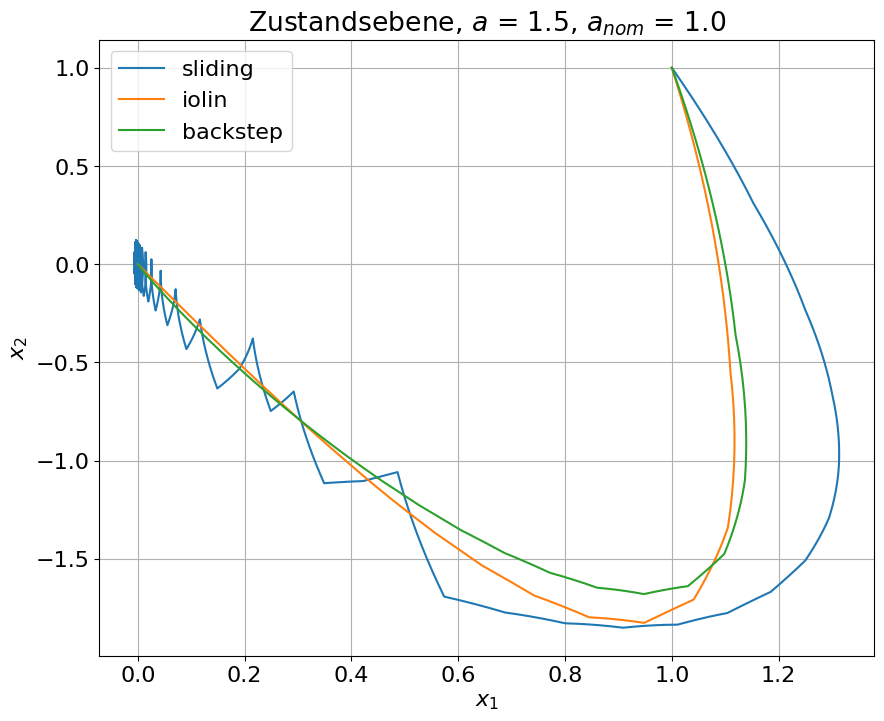

In [13]:
plt.rcParams['font.size'] = '16'
plt.figure(figsize=(10,8))
for i, case in enumerate(cases):
    plt.plot(result_x[i][0, :], result_x[i][1, :], label=case)
plt.legend()
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Zustandsebene, $a$ = {0}, $a_{{nom}}$ = {1}'.format(para_a, para_a_nom))
plt.grid()

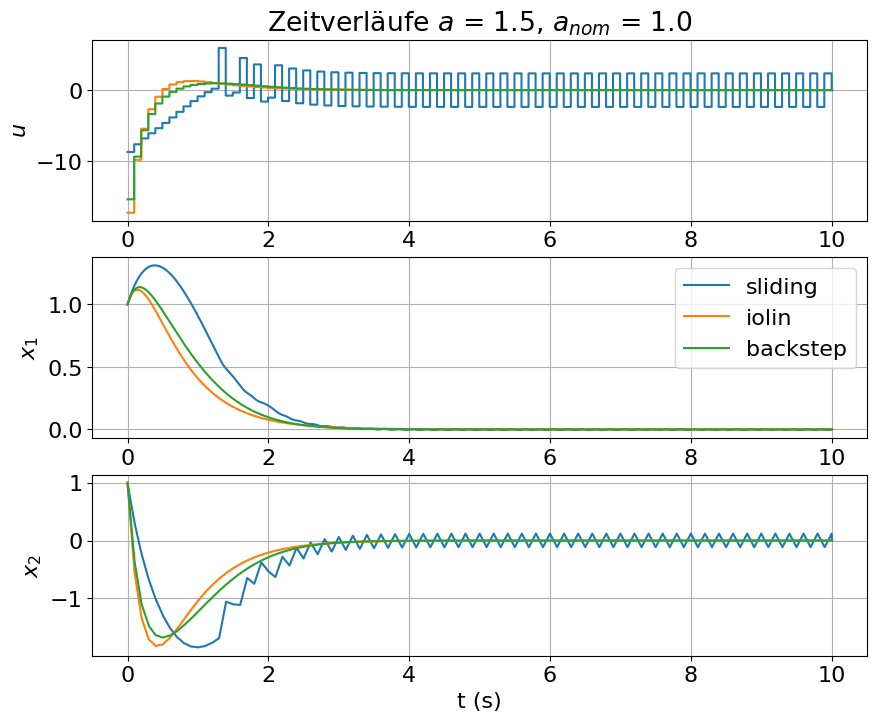

In [14]:
fig, ax = plt.subplots(3, 1)
fig.set_size_inches((10, 8))
for i, case in enumerate(cases):
    ax[0].step(result_t[i], result_u[i])
    ax[1].plot(result_t[i], result_x[i][0, :], label=case)
    ax[2].plot(result_t[i], result_x[i][1, :])

ax[0].set_title('Zeitverläufe $a$ = {0}, $a_{{nom}}$ = {1}'.format(para_a, para_a_nom))
ax[0].set_ylabel('$u$')
ax[0].grid()

ax[1].set_ylabel('$x_1$')
ax[1].grid()
ax[1].legend()

ax[2].set_ylabel('$x_2$')
ax[2].set_xlabel('t (s)')
ax[2].grid()

